#  Investigating Fairness in Data-Driven Allocation of Public Resources

---



This notebook demonstrates, through a real-world use case, how IBM's [AIF360 toolkit](https://github.com/Trusted-AI/AIF360) can be used to evaluate the fairness of an algorithm for allocating public resources. The data used was generated specifically for this workshop and therefore does not allow any conclusions to be drawn about individuals. Further assumptions that were made serve as a simplified representation of a complex problem and do not reflect the values of the presenters. 

First, a logistic regression is used to predict the risk of long-term unemployment of job seekers. If a predefined threshold is exceeded, i.e. if the probability of LTU is high according to the algorithm, the person will receive supportive measures from the public employment service.

As a protected attribute we consider the variable gender, which is binary coded here. Therefore, in a second step, we will investigate whether the prediction for LTU differs between men and women. To do so, we evaluate the Statistical Parity Difference.

Finally, we demonstrate techniques to mitigate existing biases. Here we apply reweighing, a method that assigns weights to individual instances in the training data based on frequency counts of the protected attribute and the actual outcome before classification.

## Install aif360

In [61]:
%pip install aif360

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import necessary packages

In [62]:
%matplotlib inline

import sys
sys.path.append("../")

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
from collections import OrderedDict, defaultdict
from IPython.core.display import Markdown
from IPython.display import display

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

from aif360.datasets import BinaryLabelDataset

# Classifier
from sklearn.linear_model import LogisticRegression

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

# Bias mitigation technique
from aif360.algorithms.preprocessing import Reweighing

# Set seed
seed = 1
np.random.seed(seed)

## Helper functions

In this section, helper functions are defined that can be used on different datasets or with varying thresholds. 

In [63]:
def get_dataset_with_scores(dataset, model):
    """Returns a dataset with the scores predicted by the given model.

    Args:
        dataset (BinaryLabelDataset): The dataset to be predicted.
        model(e.g. LogisticRegression): Classification model.
        """
    dataset_pred = dataset.copy(deepcopy=True)
    pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    y_pred_prob = model.predict_proba(dataset.features)[:, pos_ind]
    dataset_pred.scores = y_pred_prob.reshape(-1, 1)
    
    return dataset_pred

In [64]:
def get_label_at_threshold(dataset_pred, threshold):
    """Returns a dataset with new labels according to the specified threshold. 
    
    The instances whose score is greater than the specified threshold are assigned the favorable_label given in the BinaryLabelDataset.

    Args:
        dataset_pred (BinaryLabelDataset): BinaryLabelDataset with predicted scores.
        threshold (float): Threshold to assign labels from given scores.
        """
    dataset_pred_thresh = dataset_pred.copy(deepcopy=True)
    fav_inds = dataset_pred_thresh.scores > threshold
    dataset_pred_thresh.labels[fav_inds] = dataset_pred_thresh.favorable_label
    dataset_pred_thresh.labels[~fav_inds] = dataset_pred_thresh.unfavorable_label

    return dataset_pred_thresh

In [65]:
def get_dataset_with_predictions(dataset, model, threshold):
    """Returns a dataset with new scores predicted by the given model and new labels corresponding to the given threshold.

    Args:
        dataset (BinaryLabelDataset): The dataset to be used for prediction.
        model (e.g. LogisticRegression): Classification model.
        threshold (float): Threshold to assign labels from scores.
        """
    dataset_pred = get_dataset_with_scores(dataset, model)
    return get_label_at_threshold(dataset_pred, threshold)

In [66]:
def plot_metric_arr(ax, metric_dict, metric_transf_dict=None, thresh=None, ylim=None, hline_at=None):
    """Plots the given metric_dict on the axis specified.

    Args:
        ax (Axes): The axis to be plottet on.
        metric_dict (Dict): Dict with metrics as keys and list of metric value 
        at different thresholds as values.
        metric_transf_dict (Dict, optional): Dict with metrics as keys and list of metric value mitigation at different thresholds as values.
        thresh (float, optional): Threshold to be indicated by a dotted line in the plot.
        ylim (tuple, optional): Set ylim for given axis.
        hline_at (float, optional): If not None, hline will be highlighted at given value.
        """

    unique_keys = set(list(map(lambda x: x.split(' {')[0], metric_dict.keys())))
    for metric in unique_keys:
        dict_for_metric = {k: v for k, v in metric_dict.items() if metric in k}
        keys = list(dict_for_metric.keys())
        ax.plot(thresh_arr, dict_for_metric[keys[0]], label=keys[0])
        if len(keys) > 1:
            ax.plot(thresh_arr, dict_for_metric[keys[1]], label=keys[1], linestyle='dashed', color=ax.get_lines()[-1].get_c())
        if metric_transf_dict:
            ax.plot(thresh_arr, metric_transf_dict[metric], label=f'{metric}_transf', linestyle='dashed', color=ax.get_lines()[-1].get_c())
        ax.set_xlabel('Classification Threshold', fontsize=16, fontweight='bold')
        ax.xaxis.set_tick_params(labelsize=14)
        ax.yaxis.set_tick_params(labelsize=14)
        ax.grid(True)

        if hline_at is not None:
            ax.axhline(hline_at, linewidth=2, color='k')

        if thresh:
            thresh_ind = np.where(np.round(thresh_arr, 2) == thresh)[0][0]
            ax.axvline(np.array(thresh_arr)[thresh_ind], color='k', linestyle=':')

    if ylim:
        plt.setp([ax], ylim=ylim)
    plt.legend()

In [67]:
def plot_metrics_over_thresholds(performance_metric_dict, fairness_metric_dict, thresh_arr, threshold):
    """Plots all metrics in the given metric array over all thresholds in the given threshold array.

    Args:
        performance_metric_dict, fairness_metric_dict (Dict): Dict with metrics as keys and list of metric value 
        at different thresholds as values.
        thresh_arr (Array): Array with different thresholds.
        threshold (float, optional): Threshold to be indicated by a dotted line in the plot.
        """

    fig = plt.figure(figsize=(14, 12))
    ax1 = plt.subplot(2, 2, 1)
    plot_metric_arr(ax1, performance_metric_dict, thresh=threshold, ylim=(0 ,1))

    min_val = min([v for val_list in fairness_metric_dict.values() for v in val_list])
    max_val = max([v for val_list in fairness_metric_dict.values() for v in val_list])
    lim_val = max(abs(min_val), abs(max_val))
    custom_ylim = (-lim_val.round(1)-0.1, lim_val.round(1)+0.1)

    ax2 = plt.subplot(2, 2, 2)
    plot_metric_arr(ax2, fairness_metric_dict, thresh=threshold, ylim=custom_ylim, hline_at=0)

    fig.tight_layout()

In [68]:
def get_f1_score(classification_metric, privileged):
    """Returns the F1 score for the entire data set (privileged=None) or for a specific group. If Recall or Precision is 0, None is returned.

    Args:
        classification_metric (ClassificationMetric): Classification Metric.
        privileged (bool, optional): If True, F1 score is conditioned on the privileged_groups, or the unprivileged_groups, if False. If None, F1 score is returned for the entire data set.
        """
    if classification_metric.precision(privileged=privileged) != 0.0 and classification_metric.recall(privileged=privileged) != 0.0:
        return 2*((classification_metric.precision(privileged=privileged)*classification_metric.recall(privileged=privileged))/(classification_metric.precision(privileged=privileged) + classification_metric.recall(privileged=privileged)))
    else:
        return None

In [69]:
def get_classification_metrics(dataset_true, dataset_pred, performance_per_group):
    """Returns classification metrics for two BinaryLabelDatasets. The first dataset is the true one, the second includes the predicted scores.

    Args:
        dataset_true (BinaryLabelDataset): Dataset with true labels.
        dataset_pred (BinaryLabelDataset): Dataset with predicted scores.
        performance_per_group (bool): If yes, performance metrics will be calculated and plotted per group specified by the sensitive attribute.
        """
    performance_metrics = OrderedDict()
    fairness_metrics = OrderedDict()

    classified_metric = ClassificationMetric(dataset_true, dataset_pred,
                                                  unprivileged_groups=unprivileged_groups,
                                                  privileged_groups=privileged_groups)
        
    if performance_per_group:
        performance_metrics[f"F1 score {privileged_groups[0]}"] = get_f1_score(classified_metric, privileged=True)
        performance_metrics[f"F1 score {unprivileged_groups[0]}"] = get_f1_score(classified_metric, privileged=False)
    
        performance_metrics[f"Accuracy {privileged_groups[0]}"] = classified_metric.accuracy(privileged=True)  
        performance_metrics[f"Accuracy {unprivileged_groups[0]}"] = classified_metric.accuracy(privileged=False)
    else:
        performance_metrics["F1 score"] = get_f1_score(classified_metric, privileged=None)
        performance_metrics["Accuracy"] = classified_metric.accuracy()

    fairness_metrics["Statistical parity difference"] = classified_metric.statistical_parity_difference()
    fairness_metrics["Equal opportunity difference"] = classified_metric.equal_opportunity_difference()

    return performance_metrics, fairness_metrics

In [70]:
def get_fairness_over_thresholds(dataset, model, thresh_arr, unprivileged_groups, privileged_groups, threshold=None, dataset_with_scores=None, performance_per_group=False):
    """Plots fairness metrics over thresholds in the specified thresh_arr.

    Args:
        dataset (BinaryLabelDataset): Dataset with true labels.
        model (LogisticRegression): Classification model.
        thresh_arr (Array): Array with different thresholds.
        unprivileged_groups (list(dict)): Unprivileged groups used as input for ClassificationMetric. For details, see AIF360 documentation.
        privileged_groups (list(dict)): Privileged groups used as input for ClassificationMetric. For details, see AIF360 documentation.
        threshold (float, optional): Threshold to be indicated by a dotted line in the plot.
        dataset_with_scores (BinaryLabelDataset, optional): A dataset that already has scores assigned.
        performance_per_group (bool, optional): If yes, performance metrics will be calculated and plotted per group specified by the sensitive attribute.
        """
    if not dataset_with_scores:
        dataset_with_scores = get_dataset_with_scores(dataset, model)
    performance_metric_dict = defaultdict(list)
    fairness_metric_dict = defaultdict(list)

    for i, thresh in enumerate(thresh_arr):
        dataset_pred = get_label_at_threshold(dataset_with_scores, thresh)
        performance_metrics, fairness_metrics = get_classification_metrics(dataset, dataset_pred, performance_per_group)

        for (metric, value) in performance_metrics.items():
            performance_metric_dict[metric].append(value)
        
        for (metric, value) in fairness_metrics.items():
            fairness_metric_dict[metric].append(value)
    
    plot_metrics_over_thresholds(performance_metric_dict, fairness_metric_dict, thresh_arr, threshold)

In [71]:
def plot_metrics_transf_over_thresholds(perf_metric_dict, perf_metric_transf_dict, fair_metric_dict, fair_metric_transf_dict, thresh_arr, threshold):
    """Plots all metrics in the given metric dict and corresponding metrics for mitigated dataset (metric_transf_dict) over all thresholds in the given threshold array.

    Args:
        perf_metric_dict, fair_metric_dict (Dict): Dict with metrics as keys and list of metric value at different thresholds as values.
        perf_metric_trasnf_dict, fair_metric_transf_dict (Dict): Dict with metrics as keys and list of metric value mitigation at different thresholds as values.
        thresh_arr (Array): Array with different thresholds.
        threshold (float, optional): Threshold to be indicated by a dotted line in the plot.
        """

    fig = plt.figure(figsize=(14, 12))

    ax1 = plt.subplot(2, 2, 1)
    plot_metric_arr(ax1, perf_metric_dict, perf_metric_transf_dict, thresh=threshold, ylim=(0, 1))

    fair_metric_values = list(fair_metric_dict.values()) + list(fair_metric_transf_dict.values())
    min_val = min([v for val_list in fair_metric_values for v in val_list])
    max_val = max([v for val_list in fair_metric_values for v in val_list])
    lim_val = max(abs(min_val), abs(max_val))
    custom_ylim = (-lim_val.round(1)-0.1, lim_val.round(1)+0.1)
    ax2 = plt.subplot(2, 2, 2)
    plot_metric_arr(ax2, fair_metric_dict, fair_metric_transf_dict, thresh=threshold, ylim=custom_ylim, hline_at=0)

    fig.tight_layout()

In [72]:
def get_fairness_mitigation_over_thresholds(dataset_true, dataset_pred, dataset_transf_pred, thresh_arr, unprivileged_groups, privileged_groups, threshold=None):
    """Plots fairness metrics before and after mitigation over thresholds in the specified thresh_arr.

    Args:
        dataset_true (BinaryLabelDataset): Dataset with true labels.
        dataset_pred (BinaryLabelDataset): Dataset with predicted scores.
        dataset_transf_pred (BinaryLabelDataset): Dataset with predicted scores after mitigation.
        thresh_arr (Array): Array with different thresholds.
        unprivileged_groups (list(dict)): Unprivileged groups used as input for ClassificationMetric. For details, see AIF360 documentation.
        privileged_groups (list(dict)): Privileged groups used as input for ClassificationMetric. For details, see AIF360 documentation.
        threshold (float, optional): Threshold to be indicated by a dotted line in the plot.
        """
    perf_metric_dict = defaultdict(list)
    perf_metric_transf_dict = defaultdict(list)
    fair_metric_dict = defaultdict(list)
    fair_metric_transf_dict = defaultdict(list)

    for i, thresh in enumerate(thresh_arr):
        dataset_pred_thresh = get_label_at_threshold(dataset_pred, thresh)
        dataset_transf_pred_thresh = get_label_at_threshold(dataset_transf_pred, thresh)

        performance_metrics, fairness_metrics = get_classification_metrics(dataset_true, dataset_pred_thresh, performance_per_group=False)

        for (metric, value) in performance_metrics.items():
            perf_metric_dict[metric].append(value)
        
        for (metric, value) in fairness_metrics.items():
            fair_metric_dict[metric].append(value)

        performance_metrics_transf, fairness_metrics_transf = get_classification_metrics(dataset_true, dataset_transf_pred_thresh, performance_per_group=False)
        
        for (metric, value) in performance_metrics_transf.items():
            perf_metric_transf_dict[metric].append(value)
        
        for (metric, value) in fairness_metrics_transf.items():
            fair_metric_transf_dict[metric].append(value)
    
    print("The solid line indicates values before bias mitigation.\nThe dashed line indicates values after mitigation.")
    plot_metrics_transf_over_thresholds(perf_metric_dict, perf_metric_transf_dict, fair_metric_dict, fair_metric_transf_dict, thresh_arr, threshold)

In [73]:
def show_variable_distr(df_var, x, hue=None, legend=None):
    """Plots distribution of variables in the given dataset.

    Args:
        df_var (DataFrame): Pandas DataFrame object.
        x (str): Attribute to be plotted on the x-axis.
        hue (str): Attribute to separate data on x-axis.
        legend (list(str), optional): List of strings to use as legend values.
        """
    df_distr = df_var[[x]] if not hue else df_orig.groupby(x)[hue]
    df_distr = df_distr.value_counts(normalize=True)
    df_distr = df_distr.mul(100)
    df_distr = df_distr.rename('percent').reset_index()

    g = sns.catplot(x=x,y='percent',hue=hue,kind='bar', data=df_distr, legend=False if legend else True)
    g.ax.set_ylim(0,100)
    if legend:
        ax_legend = g.ax.legend(title=hue)
        ax_legend.texts[0].set_text(legend[0])
        ax_legend.texts[1].set_text(legend[1])

    for p in g.ax.patches:
        g.ax.annotate(f'\n{round(p.get_height(),2)}%',
                    (p.get_x() + (0.38 if not hue else 0.2),
                    p.get_height()),
                    ha='center',
                    va='top', color='black',
                    size=12)

In [74]:
def show_dataset_distributions(dataset, dataset_pred=None):
    """Print distribution of target  and sens_attr in the given dataset and the dataset_pred if specified.

    Args:
        dataset (BinaryLabelDataset): Dataset to show distributions for. 
        dataset_pred (BinaryLabelDataset, optional): If not None, show distribution for this dataset.
        """
    df = dataset.convert_to_dataframe()[0]
    display(Markdown(f"#### Dataset {target} distribution"))
    print(df.value_counts(target, normalize=True).round(4))
    display(Markdown(f"#### Dataset {sens_attr} distribution"))
    print(df.value_counts(sens_attr, normalize=True).round(4))
    display(Markdown(f"#### Dataset {target} x {sens_attr} distribution"))
    print(pd.crosstab(df[target],df[sens_attr], normalize=True).round(4))

    if dataset_pred:
        df_pred = dataset_pred.convert_to_dataframe()[0]
        target_pred = f'{target}_pred'
        df_pred = df_pred.rename(columns={target: target_pred})
        display(Markdown(f"#### Dataset {target} predicted distribution"))
        print(df_pred.value_counts(target_pred, normalize=True).round(4))
        display(Markdown(f"#### Dataset {target} x {sens_attr} predicted distribution"))
        print(pd.crosstab(df_pred[target_pred],df_pred[sens_attr], normalize=True).round(4))

In [75]:
def show_conf_matrix(dataset_true, dataset_pred, per_group=True):
    """Print confusion matrix for given datasets as markdown table. If per_group is True, confusion matrix will be shown for each subgroup of the sensitive attribute.

    Args:
        dataset, dataset_pred (BinaryLabelDataset): Datasets to show confusion matrix for. 
        per_group (bool, optional): If yes, show confusion matrix for each subgroup of the sensitive attribute.
        """

    conf_matrix_dict = OrderedDict()

    if per_group:
        df_true = dataset_true.convert_to_dataframe()[0]
        df_pred = dataset_pred.convert_to_dataframe()[0]
        for value in df_true[sens_attr].unique():
            df_true_group = df_true[df_true[sens_attr] == value]
            df_pred_group = df_pred[df_pred[sens_attr] == value]
            conf_matrix = confusion_matrix(df_true_group[target], df_pred_group[target], normalize='all')
            conf_matrix_dict[value] = conf_matrix
    else:
        conf_matrix_dict[0] = confusion_matrix(dataset_true.labels, dataset_pred.labels, normalize='all')
    
    for (k, conf_matrix) in conf_matrix_dict.items():
        if per_group:
            display(Markdown(f"#### Confusion matrix for {sens_attr} = {k}"))
        tn, fp, fn, tp = conf_matrix.ravel()
        df_metrics = pd.DataFrame({'':['LTU', 'Non LTU'],
                    'Pred LTU':[tp, fp],
                    'Pred non LTU':[fn, tn]})
        
        print(df_metrics.round(4).to_markdown(index=False))

In [76]:
def show_dataset_metrics(dataset):
    """Show dataset metrics for given dataset.

    Args:
        dataset (BinaryLabelDataset): Dataset to get dataset metrics from. 
        """
    show_dataset_distributions(dataset)

    dataset_metric = BinaryLabelDatasetMetric(
        dataset,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
    
    metric_dict = OrderedDict()
    metric_dict["Statistical parity difference"] = dataset_metric.statistical_parity_difference()

    display(Markdown(f"#### Dataset metrics"))
    for k in metric_dict:
            print(f"{k} = {metric_dict[k]:.4f}")

In [77]:
def show_classification_metrics(dataset_true, dataset_pred, performance_per_group=False):
    """Show classification metrics for given datasets.

    Args:
        dataset, dataset_pred (BinaryLabelDataset): Dataset to get classification metrics from. 
        performance_per_group (bool, optional): If yes, performance metrics will be calculated and plotted per group specified by the sensitive attribute.
        """
    show_dataset_distributions(dataset_true, dataset_pred)
    show_conf_matrix(dataset_true, dataset_pred) 
   
    performance_metrics_dict, fairness_metrics_dict = get_classification_metrics(dataset_true, dataset_pred, performance_per_group)
    classification_metrics_dict = dict(performance_metrics_dict, **fairness_metrics_dict)

    display(Markdown(f"#### Classification metrics"))
    for k in classification_metrics_dict:
        print(f"{k} = {classification_metrics_dict[k]:.4f}")

# Data generation

In the data generation phase, the data used for the prediction task is gathered, selected and, if necessary, labeled. The labels are later used to assess the "true outcome" of the variable to be predicted. In our case, this is the probability of long term unemployment (LTU).

## Loading the data

In this cell, a dataset from [GitHub](https://github.com/), a code sharing platform and version control tool, is loaded into our notebook. Then, we output the head (first five rows) of the dataframe (like a data table) to get a first impression of the data set at hand.

In [78]:
import pandas as pd
df_orig = pd.read_csv('https://raw.githubusercontent.com/achterhe/fair-ml-goethe/main/daten.csv', index_col=0)
df_orig.head()

,gender,age,occupation,income,history,ltue
1,0,50,0,3833,0,0
2,0,38,1,2194,0,0
3,0,49,0,2312,0,1
4,0,30,0,1054,0,0
5,0,49,0,766,0,1


# Data preparation and analysis

In this step, the data is first prepared to be later used as input for the classification model. The sensitive attribute is postulated, variable distributions are explored and model decisions, like the classification threshold, are specified.

In [79]:
# Set relevant variables

sens_attr = 'gender'

privileged_groups = [{sens_attr: 0}] # Male
unprivileged_groups = [{sens_attr: 1}] # Female

target = 'ltue'

threshold = 0.5
thresh_arr = np.linspace(0.01, 0.99, 99)

## Analyze the data

To gain insight into the available data, we plot the distribution of the target variable and the sensitive attribute.

#### Distribution of target variable

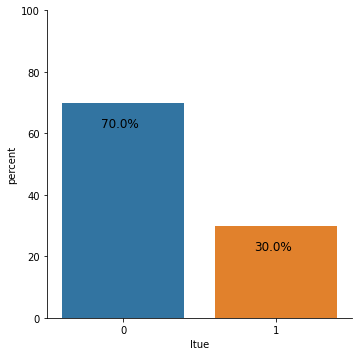

In [80]:
display(Markdown("#### Distribution of target variable"))
show_variable_distr(df_orig, target)

#### Distribution of sensitive attribute

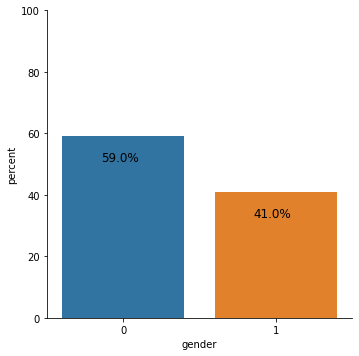

In [81]:
display(Markdown("#### Distribution of sensitive attribute"))
show_variable_distr(df_orig, sens_attr)

#### Distribution of target per sensitive attribute

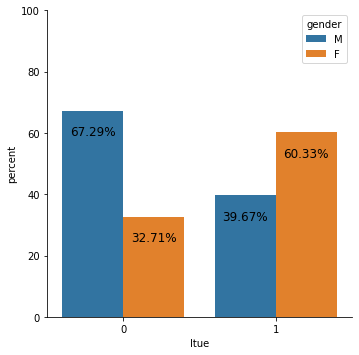

In [82]:
display(Markdown("#### Distribution of target per sensitive attribute"))
show_variable_distr(df_orig, target, hue=sens_attr, legend=['M', 'F'])

## Train-Test split

In the next step, we convert our data into a BinaryLabelDataset, a dataset type that is required for further processing of the data with the AIF360 toolkit. At this point, you may wonder about the "favorable_label" parameter, which we have set to 1 for this use case. Remember that ltue=1 means that the person is actually LTU. So is this really the favorable outcome? A look at the [documentation](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.datasets.BinaryLabelDataset.html#aif360.datasets.BinaryLabelDataset) of the BinaryLabelDataset class shows that "favorable" is used here in the same way as "positive outcome", which is more common in ML and denotes predictions that are classified as 1. However, this does not explicitly indicate whether this prediction is the desired one, but depends on interpretation. Therefore, we criticize the use of "favorable" and "unfavorable" at this point.

In [83]:
# Create a BinaryLabelDataset

dataset_orig = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=df_orig,
    label_names=[target],
    protected_attribute_names=[sens_attr]
)

Next, we split the data into a training set and a test set. A validation set is not considered for this use case. 
With a split parameter of 0.7, 70% of the instances will belong to the training data set, while 30% will be used for the test data set. By splitting the data, we are able to evaluate the performance of our model. The model learns relationships between the features in the training dataset and the true label. Next, the trained model is used to predict the results of the test data set. To evaluate the model, we then compare the predictions to the expected label we have in the test data.

In [84]:
# Split the data into training, validation and test set

dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True, seed=seed)

After the split, we can explore the training data set again

In [85]:
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes,
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(3500, 5)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['gender']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['gender', 'age', 'occupation', 'income', 'history']


## Learning a classifier

Now we will train a classifier with logistic regression on the test data and then make predictions on the test data. Performance evaluation can be done using the confusion matrix and the classification report.

In [86]:
lmod = LogisticRegression(random_state=seed, solver="liblinear")
lmod.fit(dataset_orig_train.features, dataset_orig_train.labels.ravel())

LogisticRegression(random_state=1, solver='liblinear')

In [87]:
dataset_orig_test_pred = get_dataset_with_predictions(dataset_orig_test, lmod, threshold)

In [88]:
display(Markdown(f"## Confustion matrix"))
show_conf_matrix(dataset_orig_test, dataset_orig_test_pred, per_group=False)

## Confustion matrix

|         |   Pred LTU |   Pred non LTU |
|:--------|-----------:|---------------:|
| LTU     |     0.212  |         0.102  |
| Non LTU |     0.0533 |         0.6327 |


In [89]:
display(Markdown(f"## Classification report"))
print(classification_report(dataset_orig_test.labels, dataset_orig_test_pred.labels))

## Classification report

              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89      1029
         1.0       0.80      0.68      0.73       471

    accuracy                           0.84      1500
   macro avg       0.83      0.80      0.81      1500
weighted avg       0.84      0.84      0.84      1500



## Calculate fairness metrics

In this step, the notion of fairness comes into play. Here we can distinguish between [dataset metrics](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.metrics.BinaryLabelDatasetMetric.html#aif360.metrics.BinaryLabelDatasetMetric), which can be derived from a single dataset, and [classification metrics](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.metrics.ClassificationMetric.html), which take into account the differences between true outcomes and predictions.

First, let's look at the metrics of our original test data set including the true outcome.

In [90]:
display(Markdown("## Original test dataset"))
show_dataset_metrics(dataset_orig_test)

## Original test dataset

#### Dataset ltue distribution

ltue
0.0    0.686
1.0    0.314
dtype: float64


#### Dataset gender distribution

gender
0.0    0.588
1.0    0.412
dtype: float64


#### Dataset ltue x gender distribution

gender    0.0    1.0
ltue                
0.0     0.458  0.228
1.0     0.130  0.184


#### Dataset metrics

Statistical parity difference = 0.2255


In [91]:
"""
Try to calculate the Statistical Parity Difference on your own by using the values 
given in the distribution tables above. Remember, gender=1 indicate female instances.

SPD = actually LTU women / all women - actually LTU men / all men

"""

act_ltu_women = 0
all_women = 1
act_ltu_men = 0
all_men = 1

print(act_ltu_women/all_women-act_ltu_men/all_men)

0.0


Let us now look at the classification metrics after predicting the outcome with the trained model. 

In [92]:
display(Markdown("## Predicted test dataset"))
show_classification_metrics(dataset_orig_test, dataset_orig_test_pred)

## Predicted test dataset

#### Dataset ltue distribution

ltue
0.0    0.686
1.0    0.314
dtype: float64


#### Dataset gender distribution

gender
0.0    0.588
1.0    0.412
dtype: float64


#### Dataset ltue x gender distribution

gender    0.0    1.0
ltue                
0.0     0.458  0.228
1.0     0.130  0.184


#### Dataset ltue predicted distribution

ltue_pred
0.0    0.7347
1.0    0.2653
dtype: float64


#### Dataset ltue x gender predicted distribution

gender        0.0     1.0
ltue_pred                
0.0        0.4873  0.2473
1.0        0.1007  0.1647


#### Confusion matrix for gender = 1.0

|         |   Pred LTU |   Pred non LTU |
|:--------|-----------:|---------------:|
| LTU     |     0.3042 |         0.1424 |
| Non LTU |     0.0955 |         0.4579 |


#### Confusion matrix for gender = 0.0

|         |   Pred LTU |   Pred non LTU |
|:--------|-----------:|---------------:|
| LTU     |     0.1474 |         0.0737 |
| Non LTU |     0.0238 |         0.7551 |


#### Classification metrics

F1 score = 0.7319
Accuracy = 0.8447
Statistical parity difference = 0.2285
Equal opportunity difference = 0.0145


In [93]:
"""
Try to calculate the Equal Opportunity Difference on your own by using the values 
given in the confusion matrices above. Remember, gender=1 indicate female instances.

EOD = True Positive women / all actual positive women - True Positive men / all actual positive men

"""

tp_women = 0
all_pos_women = 1
tp_men = 0
all_pos_men = 1

print(tp_women/all_pos_women-tp_men/all_pos_men)

0.0


At the beginning, we set the classification threshold to 0.5, which means that every instance where the model predicts ltue=1 with a probability greater than 0.5 is assigned ltue_pred=1. In the following cell, we plot performance metrics and fairness metrics across different thresholds to gain insight into how much the threshold affects fairness.

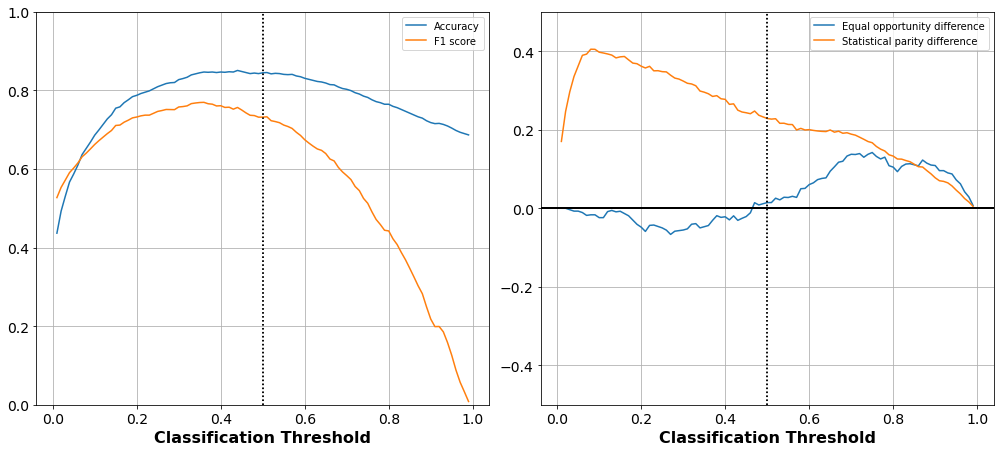

In [94]:
get_fairness_over_thresholds(dataset_orig_test, lmod, thresh_arr, unprivileged_groups, privileged_groups, threshold=threshold)

## Removing the sensitive attribute

If the algorithm is found to make its decision depending on a protected attribute, it appears obvious to simply remove this feature from the dataset to correct for the bias. So, let's omit the variable gender during training and look at the fairness metrics.

In [95]:
# Remove the variable gender from the datasets and convert them to BinaryLabelDatasets again

df_train = dataset_orig_train.convert_to_dataframe()[0]
df_train_ng = df_train.drop([sens_attr], axis=1)

df_test = dataset_orig_test.convert_to_dataframe()[0]
df_test_ng = df_test.drop([sens_attr], axis=1)

dataset_train_ng = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=df_train_ng,
    label_names=[target],
    protected_attribute_names=[]
)

dataset_test_ng = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=df_test_ng,
    label_names=[target],
    protected_attribute_names=[]
)

In [96]:
# Train a Logistic Regression on the data without gender

lmod_ng = LogisticRegression(random_state=seed, solver="liblinear")
lmod_ng.fit(dataset_train_ng.features, dataset_train_ng.labels.ravel())

LogisticRegression(random_state=1, solver='liblinear')

In [97]:
# Predict the test data set with the new model

dataset_test_ng_pred = get_dataset_with_predictions(dataset_test_ng, lmod_ng, threshold)

In [98]:
display(Markdown(f"## Confustion matrix"))
show_conf_matrix(dataset_orig_test, dataset_test_ng_pred, per_group=False)

## Confustion matrix

|         |   Pred LTU |   Pred non LTU |
|:--------|-----------:|---------------:|
| LTU     |     0.208  |         0.106  |
| Non LTU |     0.0487 |         0.6373 |


In [99]:
display(Markdown(f"## Classification report"))
print(classification_report(dataset_test_ng.labels, dataset_test_ng_pred.labels))

## Classification report

              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89      1029
         1.0       0.81      0.66      0.73       471

    accuracy                           0.85      1500
   macro avg       0.83      0.80      0.81      1500
weighted avg       0.84      0.85      0.84      1500



In [100]:
# To examine the differences between genders, we create a dataset with gender assigned the scores and labels we predicted previously

dataset_test_ng_pred_wg = dataset_orig_test.copy(deepcopy=True)
dataset_test_ng_pred_wg.scores = dataset_test_ng_pred.scores
dataset_test_ng_pred_wg.labels = dataset_test_ng_pred.labels

In [101]:
dataset_test_ng_metric = ClassificationMetric(dataset_orig_test,
        dataset_test_ng_pred_wg,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)

display(Markdown("## Predicted test dataset without sensitive attribute"))
show_classification_metrics(dataset_orig_test, dataset_test_ng_pred_wg)

## Predicted test dataset without sensitive attribute

#### Dataset ltue distribution

ltue
0.0    0.686
1.0    0.314
dtype: float64


#### Dataset gender distribution

gender
0.0    0.588
1.0    0.412
dtype: float64


#### Dataset ltue x gender distribution

gender    0.0    1.0
ltue                
0.0     0.458  0.228
1.0     0.130  0.184


#### Dataset ltue predicted distribution

ltue_pred
0.0    0.7433
1.0    0.2567
dtype: float64


#### Dataset ltue x gender predicted distribution

gender       0.0     1.0
ltue_pred               
0.0        0.460  0.2833
1.0        0.128  0.1287


#### Confusion matrix for gender = 1.0

|         |   Pred LTU |   Pred non LTU |
|:--------|-----------:|---------------:|
| LTU     |     0.2524 |         0.1942 |
| Non LTU |     0.0599 |         0.4935 |


#### Confusion matrix for gender = 0.0

|         |   Pred LTU |   Pred non LTU |
|:--------|-----------:|---------------:|
| LTU     |     0.1769 |         0.0442 |
| Non LTU |     0.0408 |         0.7381 |


#### Classification metrics

F1 score = 0.7290
Accuracy = 0.8453
Statistical parity difference = 0.0946
Equal opportunity difference = -0.2348


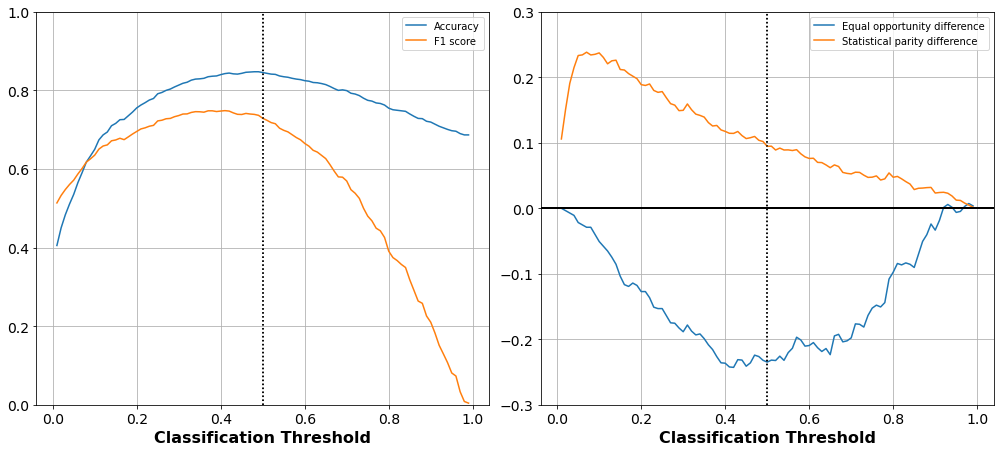

In [102]:
get_fairness_over_thresholds(dataset_orig_test, lmod, thresh_arr, unprivileged_groups, privileged_groups, threshold=threshold, dataset_with_scores=dataset_test_ng_pred_wg)

# Add-on

## Bias mitigation

To demonstrate the use of bias mitigation algorithms, we apply reweighing to the data at hand. This algorithm assigns a weight to each instance with respect to its sens_attr value and its true outcome. A classifier is then trained with the new instance weights.

In [103]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_orig_train)

In [104]:
display(Markdown("## Transformed training dataset"))
show_dataset_metrics(dataset_transf_train)

## Transformed training dataset

#### Dataset ltue distribution

ltue
0.0    0.706
1.0    0.294
dtype: float64


#### Dataset gender distribution

gender
0.0    0.5909
1.0    0.4091
dtype: float64


#### Dataset ltue x gender distribution

gender     0.0     1.0
ltue                  
0.0     0.4766  0.2294
1.0     0.1143  0.1797


#### Dataset metrics

Statistical parity difference = 0.0000


### Train classifier on transformed data

In [105]:
lmod_transf = LogisticRegression(random_state=seed, solver="liblinear")
lmod_transf = lmod_transf.fit(dataset_transf_train.features, dataset_transf_train.labels.ravel(), sample_weight=dataset_transf_train.instance_weights)

In [106]:
dataset_transf_test_pred = get_dataset_with_predictions(dataset_orig_test, lmod_transf, threshold)

In [107]:
display(Markdown(f"## Confustion matrix"))
show_conf_matrix(dataset_orig_test, dataset_transf_test_pred, per_group=False)

## Confustion matrix

|         |   Pred LTU |   Pred non LTU |
|:--------|-----------:|---------------:|
| LTU     |     0.2027 |         0.1113 |
| Non LTU |     0.0487 |         0.6373 |


In [108]:
display(Markdown(f"## Classification report"))
print(classification_report(dataset_orig_test.labels, dataset_transf_test_pred.labels))

## Classification report

              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89      1029
         1.0       0.81      0.65      0.72       471

    accuracy                           0.84      1500
   macro avg       0.83      0.79      0.80      1500
weighted avg       0.84      0.84      0.83      1500



In [109]:
display(Markdown("## Predicted transformed test dataset"))
show_classification_metrics(dataset_orig_test, dataset_transf_test_pred)

## Predicted transformed test dataset

#### Dataset ltue distribution

ltue
0.0    0.686
1.0    0.314
dtype: float64


#### Dataset gender distribution

gender
0.0    0.588
1.0    0.412
dtype: float64


#### Dataset ltue x gender distribution

gender    0.0    1.0
ltue                
0.0     0.458  0.228
1.0     0.130  0.184


#### Dataset ltue predicted distribution

ltue_pred
0.0    0.7487
1.0    0.2513
dtype: float64


#### Dataset ltue x gender predicted distribution

gender        0.0     1.0
ltue_pred                
0.0        0.4593  0.2893
1.0        0.1287  0.1227


#### Confusion matrix for gender = 1.0

|         |   Pred LTU |   Pred non LTU |
|:--------|-----------:|---------------:|
| LTU     |     0.2395 |         0.2071 |
| Non LTU |     0.0583 |         0.4951 |


#### Confusion matrix for gender = 0.0

|         |   Pred LTU |   Pred non LTU |
|:--------|-----------:|---------------:|
| LTU     |     0.1769 |         0.0442 |
| Non LTU |     0.042  |         0.737  |


#### Classification metrics

F1 score = 0.7170
Accuracy = 0.8400
Statistical parity difference = 0.0789
Equal opportunity difference = -0.2638


The solid line indicates values before bias mitigation.
The dashed line indicates values after mitigation.


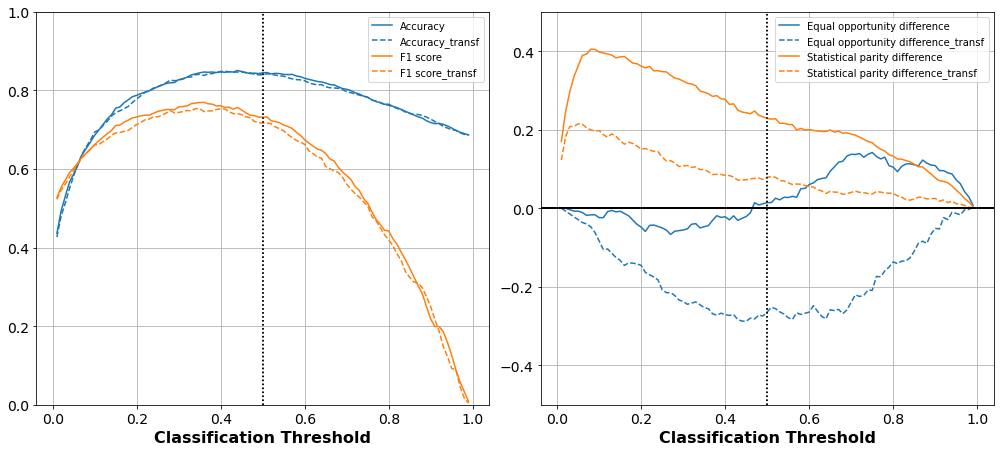

In [110]:
get_fairness_mitigation_over_thresholds(dataset_orig_test, dataset_orig_test_pred, dataset_transf_test_pred, thresh_arr, unprivileged_groups, privileged_groups, threshold)

## Applying a Random Forest model

Of course, it is possible to use a model other than logistic regression for this classification problem. The following cells show the use of a Random Forest classifier and the resulting fairness evaluation.

In [111]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=100, random_state=seed)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(dataset_orig_train.features, dataset_orig_train.labels.ravel())

RandomForestClassifier(random_state=1)

In [112]:
dataset_orig_test_pred_rf = get_dataset_with_predictions(dataset_orig_test, rf, threshold)

In [113]:
display(Markdown(f"## Confustion matrix"))
show_conf_matrix(dataset_orig_test, dataset_orig_test_pred_rf, per_group=False)

## Confustion matrix

|         |   Pred LTU |   Pred non LTU |
|:--------|-----------:|---------------:|
| LTU     |     0.21   |         0.104  |
| Non LTU |     0.0693 |         0.6167 |


In [114]:
display(Markdown(f"## Classification report"))
print(classification_report(dataset_orig_test.labels, dataset_orig_test_pred_rf.labels))

## Classification report

              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88      1029
         1.0       0.75      0.67      0.71       471

    accuracy                           0.83      1500
   macro avg       0.80      0.78      0.79      1500
weighted avg       0.82      0.83      0.82      1500



In [115]:
display(Markdown("## Predicted test dataset"))
show_classification_metrics(dataset_orig_test, dataset_orig_test_pred_rf)

## Predicted test dataset

#### Dataset ltue distribution

ltue
0.0    0.686
1.0    0.314
dtype: float64


#### Dataset gender distribution

gender
0.0    0.588
1.0    0.412
dtype: float64


#### Dataset ltue x gender distribution

gender    0.0    1.0
ltue                
0.0     0.458  0.228
1.0     0.130  0.184


#### Dataset ltue predicted distribution

ltue_pred
0.0    0.7207
1.0    0.2793
dtype: float64


#### Dataset ltue x gender predicted distribution

gender        0.0     1.0
ltue_pred                
0.0        0.4693  0.2513
1.0        0.1187  0.1607


#### Confusion matrix for gender = 1.0

|         |   Pred LTU |   Pred non LTU |
|:--------|-----------:|---------------:|
| LTU     |     0.2718 |         0.1748 |
| Non LTU |     0.1181 |         0.4353 |


#### Confusion matrix for gender = 0.0

|         |   Pred LTU |   Pred non LTU |
|:--------|-----------:|---------------:|
| LTU     |     0.1667 |         0.0544 |
| Non LTU |     0.0351 |         0.7438 |


#### Classification metrics

F1 score = 0.7079
Accuracy = 0.8267
Statistical parity difference = 0.1882
Equal opportunity difference = -0.1452


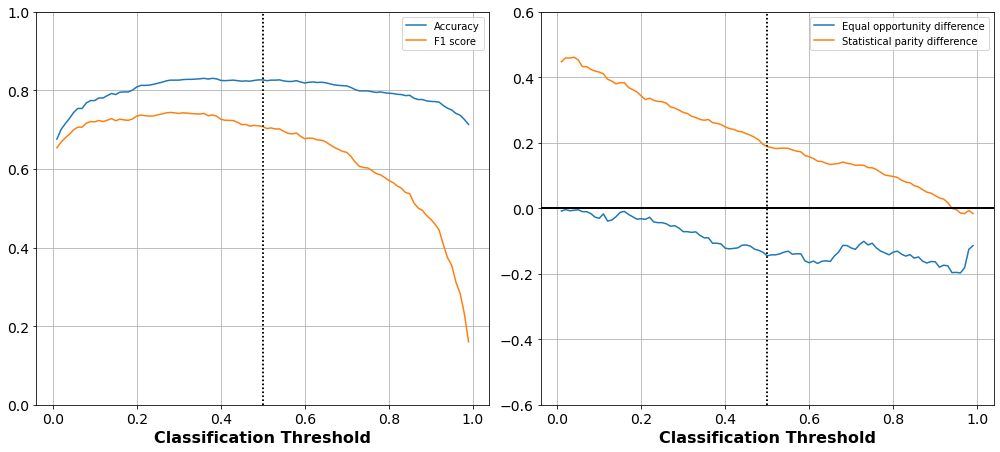

In [116]:
get_fairness_over_thresholds(dataset_orig_test, rf, thresh_arr, unprivileged_groups, privileged_groups, threshold=threshold)

## Investigate performance per group

In [117]:
display(Markdown("## Predicted test dataset"))
show_classification_metrics(dataset_orig_test, dataset_orig_test_pred, performance_per_group=True)

## Predicted test dataset

#### Dataset ltue distribution

ltue
0.0    0.686
1.0    0.314
dtype: float64


#### Dataset gender distribution

gender
0.0    0.588
1.0    0.412
dtype: float64


#### Dataset ltue x gender distribution

gender    0.0    1.0
ltue                
0.0     0.458  0.228
1.0     0.130  0.184


#### Dataset ltue predicted distribution

ltue_pred
0.0    0.7347
1.0    0.2653
dtype: float64


#### Dataset ltue x gender predicted distribution

gender        0.0     1.0
ltue_pred                
0.0        0.4873  0.2473
1.0        0.1007  0.1647


#### Confusion matrix for gender = 1.0

|         |   Pred LTU |   Pred non LTU |
|:--------|-----------:|---------------:|
| LTU     |     0.3042 |         0.1424 |
| Non LTU |     0.0955 |         0.4579 |


#### Confusion matrix for gender = 0.0

|         |   Pred LTU |   Pred non LTU |
|:--------|-----------:|---------------:|
| LTU     |     0.1474 |         0.0737 |
| Non LTU |     0.0238 |         0.7551 |


#### Classification metrics

F1 score {'gender': 0} = 0.7514
F1 score {'gender': 1} = 0.7189
Accuracy {'gender': 0} = 0.9025
Accuracy {'gender': 1} = 0.7621
Statistical parity difference = 0.2285
Equal opportunity difference = 0.0145


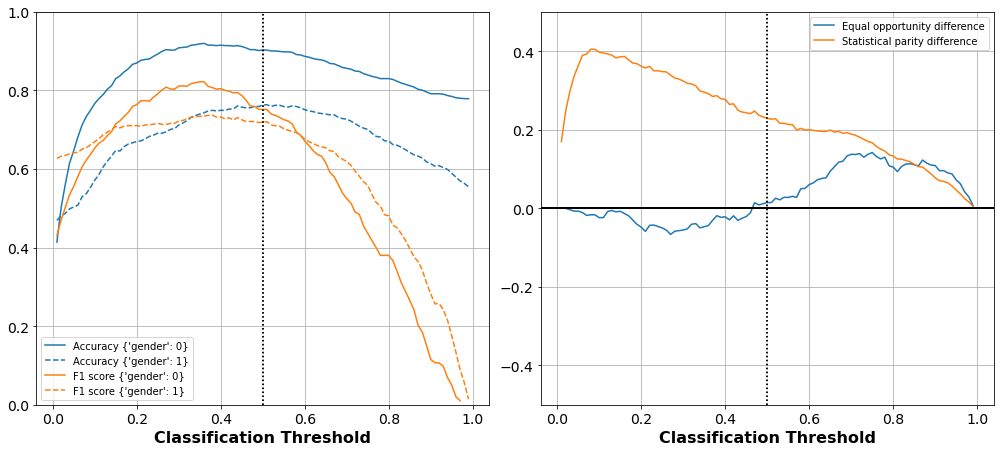

In [118]:
get_fairness_over_thresholds(dataset_orig_test, lmod, thresh_arr, unprivileged_groups, privileged_groups, threshold=threshold, performance_per_group=True)